# Caso 1. Análisis de una fabricación de queso camembert usando `Python` y Google Colab.

En este ejercicio usaremos un fichero o archivo de datos en formato CSV que habremos exportado previamente desde nuestra hoja de cálculo. Más adelante aprenderemos cómo leer directamente los datos de nuestras hojas Excel.

[Abrir este cuaderno en Google Colab/](https://colab.research.google.com/github/juanriera/master-queseria/blob/master/040-caso1-camembert.ipynb)

[Descargar los datos de ejemplo `camembert.csv` usados en este cuaderno](https://raw.githubusercontent.com/juanriera/master-queseria/master/datos/camembert.csv)

## Flujo de trabajo

Coo vimos en el capítulo 2, es muy conveniente establecer un flujo de trabajo regular, de forma que cada etapa del análisis sea un paso que se apoye en los anteriores.

Este flujo de trabajo debe cubrir las etapas que veíamos en ese capítulo:

![](01-imagenes/data-science-explore.svg)

Vamos a ir desarrollando este flujo paso a paso.

### 1. Importar los datos

En este cuaderno vamos a cargar los datos desde GitHub; estos datos pueden ser descargados en el ordenador o Google Drive de cada uno, junto con el cuaderno, en los enlaces facilitados al principio. Una vez en Drive, puede leerse la tabla mediante el método que vimos al final del capítulo anterior.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

url_datos = 'https://raw.githubusercontent.com/juanriera/master-queseria/master/datos/camembert.csv'

try:
    df = pd.read_csv(url_datos, decimal = ",", sep=';', encoding='ISO-8859-1')
    print("¡Archivo ", url_datos," cargado correctamente!")
    print(f"Dimensiones de los datos: {df.shape}")
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

¡Archivo  https://raw.githubusercontent.com/juanriera/master-queseria/master/datos/camembert.csv  cargado correctamente!
Dimensiones de los datos: (211, 7)


Vemos el `dataframe` que hemos leído, mediante la funcion `.head()`, que nos muestra las cinco primeras lineas.

In [2]:
df.head()

,fecha,fabricacion,est,mg,ph,cloruros,coliformes
0,11/01/2020,1,46.68,24.0,4.85,1.50,80.0
1,12/01/2020,1,48.09,25.0,4.67,1.61,0.0
2,13/01/2020,1,45.97,24.0,4.71,1.48,9200.0
3,14/01/2020,1,46.24,23.5,4.78,1.69,20.0
4,15/01/2020,1,45.81,23.0,4.77,1.56,150.0


Verificamos la estructura interna de nuestro `dataframe` y el tipo de los datos (entero, numérico, carácter...) mediante la función `.info()`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fecha        211 non-null    object 
 1   fabricacion  211 non-null    int64  
 2   est          211 non-null    float64
 3   mg           211 non-null    float64
 4   ph           211 non-null    float64
 5   cloruros     211 non-null    float64
 6   coliformes   210 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 11.7+ KB


Como resultado de la importación el `csv`, la `fecha` aparece como columna `object`; nos interesa convertirla en un formato de fecha que `pandas` pueda reconocer.

In [4]:
df['fecha'] = pd.to_datetime(
    df['fecha'], 
    format='%d/%m/%Y',  
    errors='coerce' # Si hay una fecha inválida, la convierte a 'NaT' (Not a Time) en lugar de fallar.
)

> Recuerda que si no comprendes bien el código, puedes copiarlo y pegarlo en Google Gemini y pedir a Gemini una explicación detallada de lo que hace.

Verificamos la conversión:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fecha        211 non-null    datetime64[ns]
 1   fabricacion  211 non-null    int64         
 2   est          211 non-null    float64       
 3   mg           211 non-null    float64       
 4   ph           211 non-null    float64       
 5   cloruros     211 non-null    float64       
 6   coliformes   210 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 11.7 KB


Ahora la fecha tiene formato `datetime64` que es el formato de fecha que reconoce `pandas`.

### 2. Ordenar/limpiar los datos

La tabla de datos que hemos leído ya está en un formato *tidy*: una línea por observación y una columna por medida, como comprobamos inspeccionando las primera lineas de código:


In [6]:
df.head()

,fecha,fabricacion,est,mg,ph,cloruros,coliformes
0,2020-01-11,1,46.68,24.0,4.85,1.50,80.0
1,2020-01-12,1,48.09,25.0,4.67,1.61,0.0
2,2020-01-13,1,45.97,24.0,4.71,1.48,9200.0
3,2020-01-14,1,46.24,23.5,4.78,1.69,20.0
4,2020-01-15,1,45.81,23.0,4.77,1.56,150.0


Vamos entonces a verificar que los valores que hemos leído son correctos.
¿Qué tenemos que buscar?

* Valores mal introducidos que `Python`no tiene por qué saber que son erróneos (por ejemplo, un pH de 51,5 en vez de 5,15)
* Valores anormalmente altos o bajos, que pueden indicar errores de medida, de toma de muestras o de introducción de datos (por ejemplo, un pH de leche de 30, que puede indicar una lectura de temperatura introducida fuera de sitio)
* Valores erróneos: por ejemplo, valores negativos en cualquier medida
* Una distribucion de los datos anormal: 
    * por ejemplo, el pH de un queso debería tener la mayor frecuencia entorno al pH objetivo, y desviaciones con una frecuencia cada vez más baja a medida que se alejan del valor central
    * en cambio, los recuentos de bacterias coliformes deberían tener la mayor frecuencia en los valores cero o muy bajos, y la distribución no debería ser simétrica

En general, cualquier cosa que nos llame la atención en los datos y que debemos explicar.

Para hacer esta verificación, analizamos cada variable (columna) por separado.

### 3. Visualizar: Análisis gráfico
Comenzamos el análisis estudiando la variable o columna `est`, que almacena los valores de **extracto seco total**. Utilizamos las herramientas gráficas que conocemos: **histograma** y **diagrama de caja**. Por el momento no nos preocupamos de rotular el gráfico, estamos simplemente explorando de forma rápida.

#### El histograma

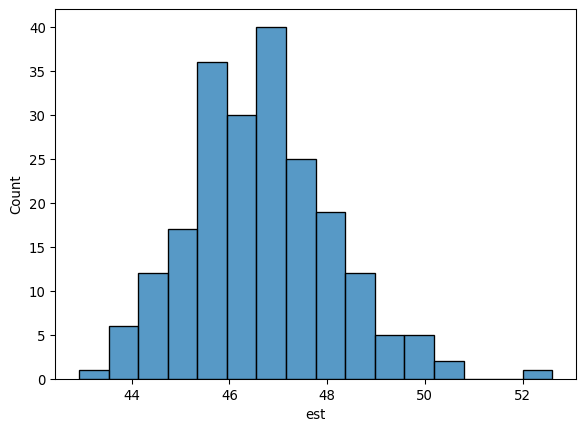

In [7]:
sns.histplot(df["est"])
plt.show()

También podemos utilizar `seaborn`, que nos permite incluir la curva de densidad de forma muy sencilla.

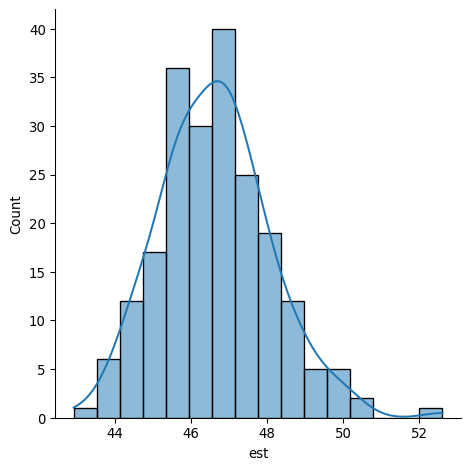

In [8]:
sns.displot(df["est"], kde = True)

plt.show()

El histograma nos muestra la mayor frecuencia en torno a los valores centrales, la distribución es aproximadamente simétrica, y parece tener algún valor anormalmente alto (52). ¿Debería preocuparnos este valor? ¿Es razonable o puede ser un error?

La curva de densidad muestra algo que debe resultarnos sospechoso: hay una subida en torno a 52. Una curva de distribución que fuese semejante a una **campana de Gauss** (distribución *normal*) no debería mostrar uncambio en sus extremos, sino amortiguarse suavemente hasta cero.


Continuamos explorando con el *boxplot*.

#### El *boxplot*

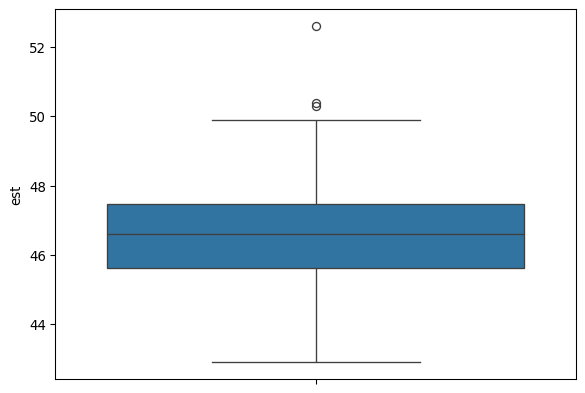

In [9]:
sns.boxplot(df['est'])

plt.show()

El *boxplot* nos indica que no sólo el valor ligeramente por encima de 52 parece anormal, también lo parecen algunos valores por encima de 50.

### Los gráficos de *series temporales*

Ya sabemos que paree haber algún valor atípico, anormalmente alto, en nuestros datos. ¿Cómo podemos profundizar un poco más y decidir si debemos excluir estos valores analíticos?

Sabemso que estos resultados se han obtenido a lo largo de un año. ¿Puede haber pasado algo en algún momento que haya hecho que algunos resultados se hayan desviado? Veamos cuál ha sido la evolución anual del extracto seco total de nuestra fabricación.

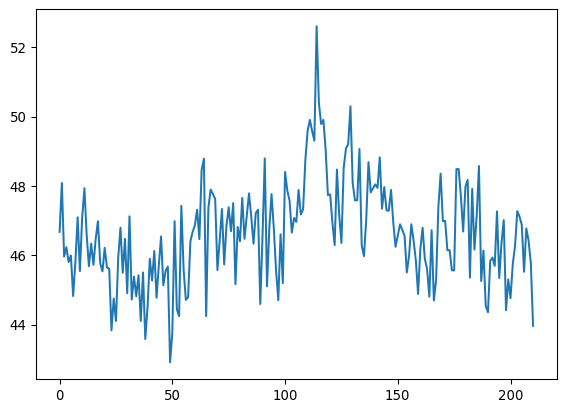

In [10]:
df['est'].plot()
plt.show()

El gráfico representa los valores individuales de manera secuencial, y el eje X muestra el número de orden del valor. Sería mucho más útil si este eje estuviera rotulado con fechas. `Seaborn` puede ayudarnos con esto.

[]

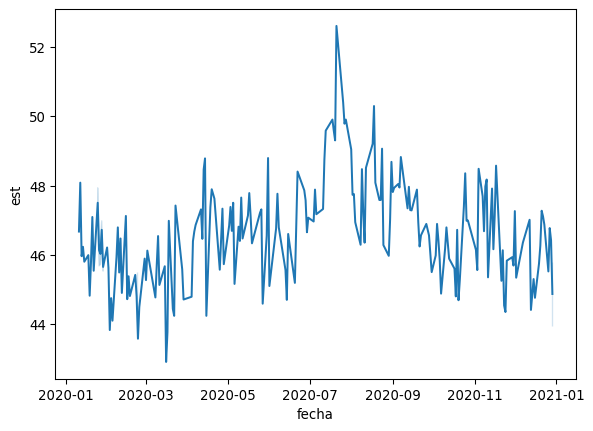

In [11]:
sns.lineplot(data= df, x='fecha', y='est')
plt.plot()

Como hemos convertido la columna `fecha` a un formato de fecha, `seaborn`la reconoce y rotula el eje correctamente. 

Vemos estos valores anormales se han producido en el verano, en torno a julio-agosto. En esta época ha habido una subida de los valores de extracto seco total. A la vista del gráfico, los valores por encima de 50, aunque extremos, parece que están dentro de un momento en el que el extracto seco se había desviado hacia arriba. Esto sitúa a esos valores en un contexto temporal en el que probablemente puede que no fueran tan anormales. ¿Qué quiere decir esto? Pues que si un valor de 52 es *atípico* frente al conjunto de datos completo, es posible que no lo sea si los valores que lo rodean también lo eran.

Vamos a explorar esto un poco más y mostrar los datos por meses, para ver si considerados mes a mes, el valor de 52 sigue pareciendo anormal, y vamos a utilizar también `pandas`para hacer los gráficos de series.

Para representar los datos por mes con `pandas`, tenemos que crear una columna índice con la fecha:

In [12]:
df['fecha_index']= pd.DatetimeIndex(df.fecha).normalize()
df.set_index('fecha_index',inplace=True)
df.sort_index(inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 211 entries, 2020-01-11 to 2020-12-29
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fecha        211 non-null    datetime64[ns]
 1   fabricacion  211 non-null    int64         
 2   est          211 non-null    float64       
 3   mg           211 non-null    float64       
 4   ph           211 non-null    float64       
 5   cloruros     211 non-null    float64       
 6   coliformes   210 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 13.2 KB


Ahora nos aparece un *DateTimeIndex* que no está entre las columnas, pero que muestra entradas desde el 11/1/2020 hasta el 29/12/2020. Usamos este índice para crear una columna con el mes:

In [14]:
df['mes'] = df.index.month

Veamos la columna en nuestro *DataFrame*:

In [15]:
df.head()

,fecha,fabricacion,est,mg,ph,cloruros,coliformes,mes
fecha_index,,,,,,,,
2020-01-11,2020-01-11,1,46.68,24.0,4.85,1.50,80.0,1
2020-01-12,2020-01-12,1,48.09,25.0,4.67,1.61,0.0,1
2020-01-13,2020-01-13,1,45.97,24.0,4.71,1.48,9200.0,1
2020-01-14,2020-01-14,1,46.24,23.5,4.78,1.69,20.0,1
2020-01-15,2020-01-15,1,45.81,23.0,4.77,1.56,150.0,1


Ahora podemos agrupar nuestros valores por meses, y comprobar los valores anormales *dentro de cada mes*. Para ello, simplemente indicamos a `seaborn` la variable que va a estar en el eje X:

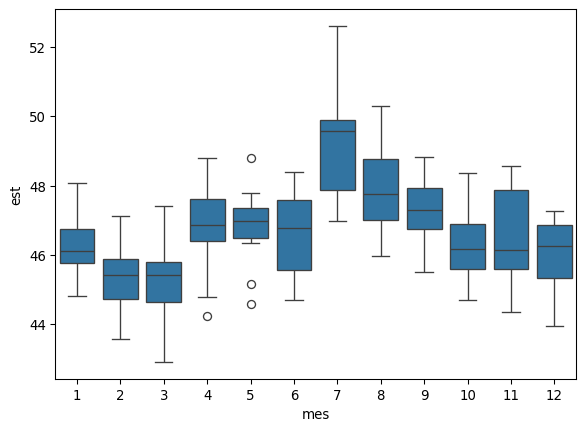

In [16]:
sns.boxplot(x='mes', y='est', data=df)

plt.show()

En vez de usar el número para el mes, podemos usar el código de letras abreviado. En este caso, `seaborn`utiliza la abreviatura en inglés , pero podríamos cambiar la codificación para que lo represente en español con la instruccion `locale`: queda como ejercicio personal). Aprovechamos para personalizar un poco el gráfico.

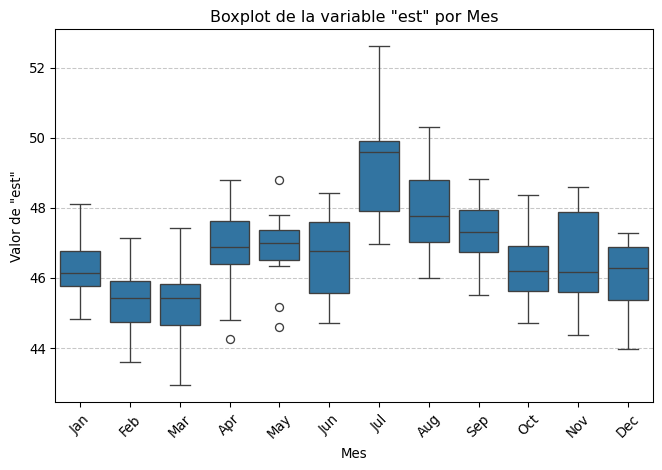

In [17]:
df['mes_abreviado'] = df.index.strftime('%b')
sns.boxplot(x='mes_abreviado', y='est', data=df)
# Opcional: Personalizar el gráfico
plt.title('Boxplot de la variable "est" por Mes')
plt.xlabel('Mes')
plt.ylabel('Valor de "est"')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Añadir una cuadrícula para mejor lectura
plt.xticks(rotation=45) # Rotar las etiquetas del eje X si son muchas
plt.tight_layout() # Ajusta automáticamente los parámetros de la subtrama para un diseño ajustado
plt.show()


¡Ahora nuestra visión de los datos ha cambiado! Resulta que los valores anaíticos de extracto seco han ido variando a lo largo del año, y el valor supuestamente anómalo de 52 ya no lo es considerando los datos mes a mes, porque *todos lo valores de julio* han sido muy altos, y 52 no parece extremo en este contexto. En cambio, vemos que en mayo sí ha habido valores anómalos en relación a los obtenidos en el mes. ¿Debe preocuparnos? Probablemente no, porque están dentro del conjunto de los valores anuales. Los valores de julio sí parecen excesivamente altos casi durante todo el mes. Vamos a detallar un poco más, viendo los valores semanales:

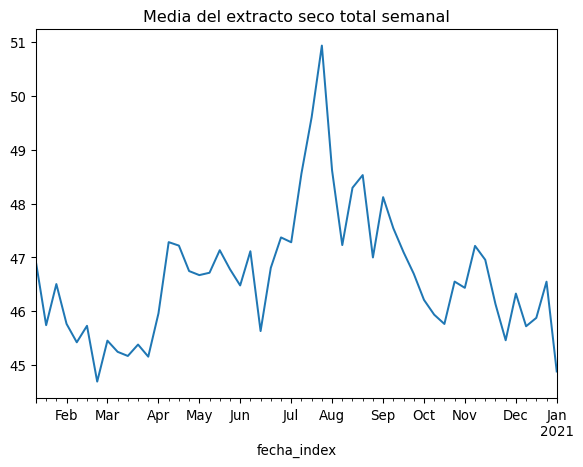

In [18]:
df["est"].resample('W-MON').mean().plot(title="Media del extracto seco total semanal");
plt.show()

Haganos un zoom en los valores de julio y agosto:

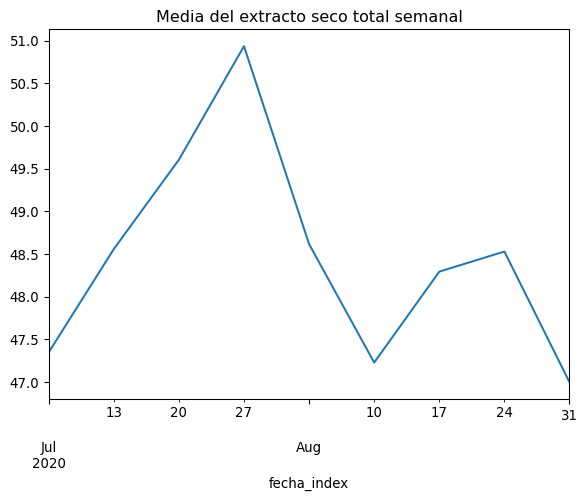

In [19]:
df["est"]["2020-07":"2020-08"].resample('W-MON').mean().plot(title="Media del extracto seco total semanal");
plt.show()

Efectivamente, las semanas de julio han tenido valores crecientes de extracto seco, y esto no se ha corregido hasta el mes de agosto. En realidad, a partir de octubre se habajado el extracto seco de nuevo a valores más cercanos a los del primer semestre. Aunque podemos pensar en posibles causas, vamos a hacer el mismo análisis en la materia grasa, antes de lanzar una hipótesis de trabajo que explique esta desviación.

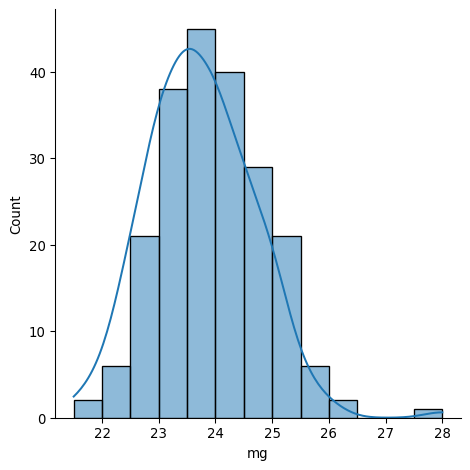

In [20]:
sns.displot(df["mg"], kde = True)

plt.show()

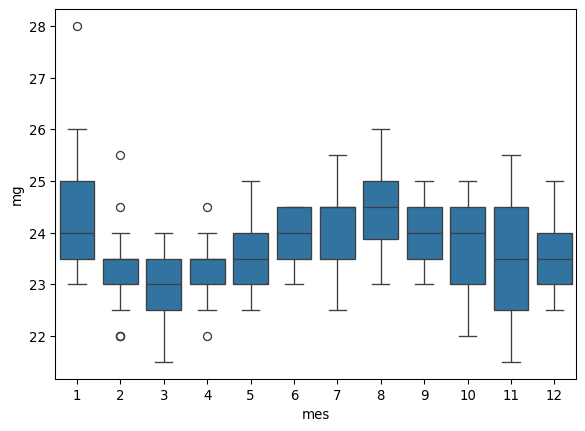

In [21]:
sns.boxplot(x='mes', y='mg', data=df)

plt.show()

Vemos que también en la materia grasa hay valores anormales, el único que parece fuera de contexto es el valor anormal de enero.

En general, cuando en una fabricación de queso aumenta el extracto seco, lo más común es que aumente también la materia grasa, que forma parte de ese extracto seco. ¿Cómo han variado la `mg` y el `est`durante el perído que estamos considerando? Veámoslo con un diagrama de dispersión:


[]

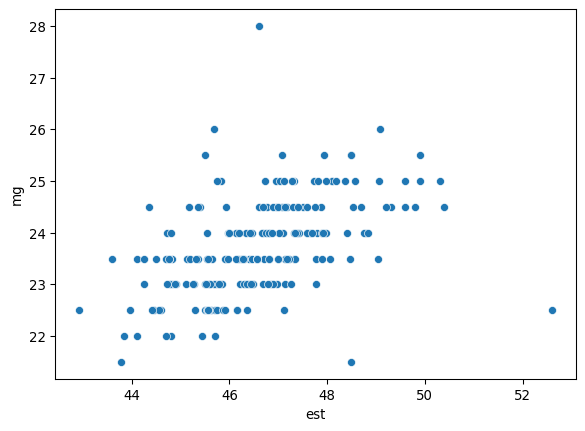

In [22]:
sns.scatterplot(data=df, x='est', y='mg')
plt.plot()

`Seaborn` Nos permite incluir una zona de confianza o *intervalo de confianza* para los valores que varían conjuntamente; utilizaremos la curva equivalente a la función de densidad que veíamos en el histograma:

[]

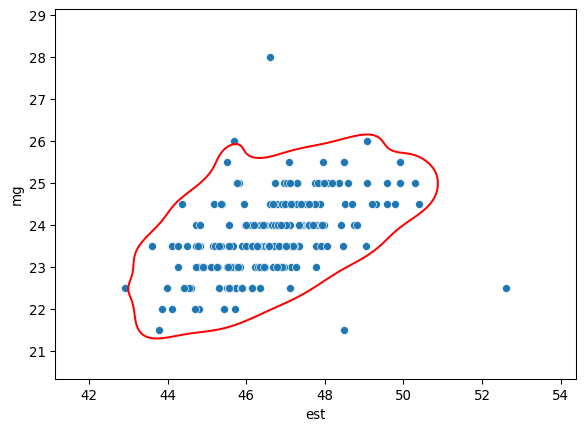

In [23]:
sns.scatterplot(data=df, x='est', y='mg')
sns.kdeplot(data=df, x='est', y='mg', levels=2, color='r', linewidths=1.5)
plt.plot()


`Seaborn` tiene un gráfico muy interesante que nos permite ver ambas variables en un gráfico conjunto, que nos muestra histogramas y un diagrama de dispersión.

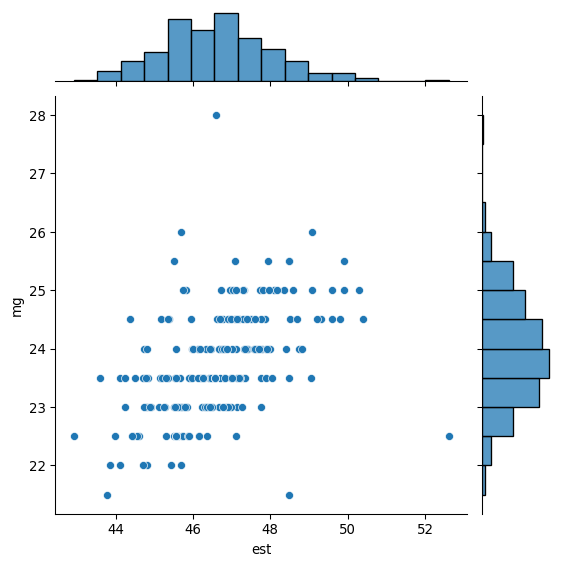

In [24]:
sns.jointplot(
    x="est", 
    y="mg", 
    data = df
)
plt.show()

En estos dos gráficos, vemos que hay varios valores, al menos tres, que podríamos considerar al menos como sospechosos:

1. El valor de 52 de extracto seco total
2. El valor de 28 de materia grasa
3. Un valor que los *boxplot* no nos habían detectado, por debajo de 22 de `mg` y por encima de 48 de `est`, lo que resulta anormal dentro de la composición habitual del queso.

Antes de pasar al análisis y conclusiones, veamos dos gráficos complementarios de los anteriores, que muestran simultáneamente la media y la desviación típica semanales del extracto seco y la materia grasa,

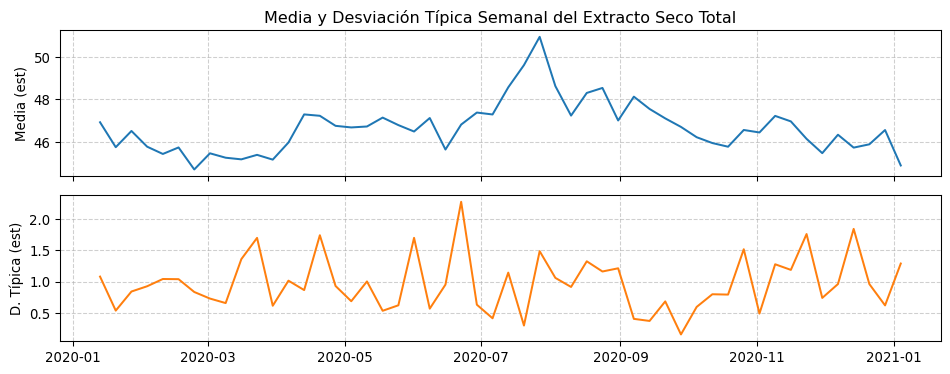

In [25]:
# --- 1. Preparación de los datos (Calculando la Media y la Desviación Típica Semanal) ---
media_semanal = df["est"].resample('W-MON').mean()
dt_semanal = df["est"].resample('W-MON').std()

# --- 2. Creación de los Subgráficos (El paso clave) ---
# Creamos una figura (conjunto de gráficos) con 2 filas y 1 columna.
# El parámetro 'figsize=(10, 4)' controla el tamaño: 10 de ancho y 4 de alto total (como un gráfico normal).
# 'sharex=True' asegura que ambos gráficos compartan el mismo eje temporal.
fig, (ax1, ax2) = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(10, 4), 
    sharex=True
)

# --- 3. Graficar la Media (Gráfico Superior) ---
ax1.plot(media_semanal, label="Media Semanal", color='tab:blue')
ax1.set_title("Media y Desviación Típica Semanal del Extracto Seco Total")
ax1.set_ylabel("Media (est)")
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(labelbottom=False) # Quita las etiquetas de fecha/hora del gráfico superior

# --- 4. Graficar la Desviación Típica (Gráfico Inferior) ---
ax2.plot(dt_semanal, label="Desviación Típica Semanal", color='tab:orange')
ax2.set_ylabel("D. Típica (est)")
ax2.grid(True, linestyle='--', alpha=0.6)

# Ajusta el espacio entre los gráficos para que no se superpongan
fig.tight_layout() 
plt.show()

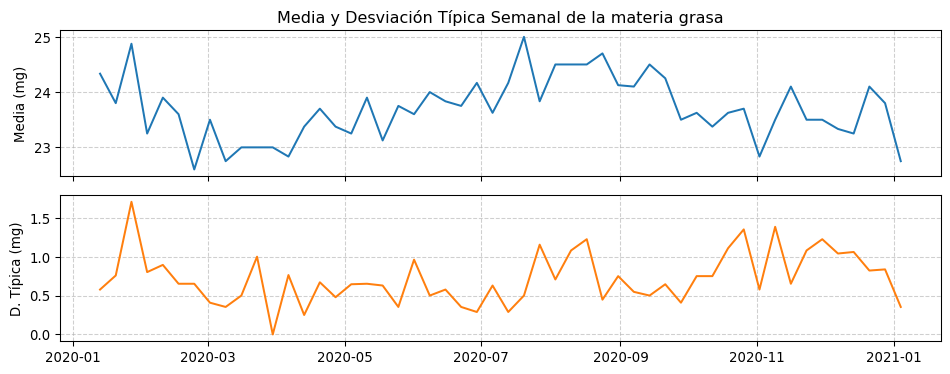

In [26]:
# --- 1. Preparación de los datos (Calculando la Media y la Desviación Típica Semanal) ---
media_semanal = df["mg"].resample('W-MON').mean()
dt_semanal = df["mg"].resample('W-MON').std()

# --- 2. Creación de los Subgráficos (El paso clave) ---
# Creamos una figura (conjunto de gráficos) con 2 filas y 1 columna.
# El parámetro 'figsize=(10, 4)' controla el tamaño: 10 de ancho y 4 de alto total (como un gráfico normal).
# 'sharex=True' asegura que ambos gráficos compartan el mismo eje temporal.
fig, (ax1, ax2) = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(10, 4), 
    sharex=True
)

# --- 3. Graficar la Media (Gráfico Superior) ---
ax1.plot(media_semanal, label="Media Semanal", color='tab:blue')
ax1.set_title("Media y Desviación Típica Semanal de la materia grasa")
ax1.set_ylabel("Media (mg)")
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(labelbottom=False) # Quita las etiquetas de fecha/hora del gráfico superior

# --- 4. Graficar la Desviación Típica (Gráfico Inferior) ---
ax2.plot(dt_semanal, label="Desviación Típica Semanal", color='tab:orange')
ax2.set_ylabel("D. Típica (mg)")
ax2.grid(True, linestyle='--', alpha=0.6)

# Ajusta el espacio entre los gráficos para que no se superpongan
fig.tight_layout() 
plt.show()

Como tecnólogos queseros, sabemos que un factor crítico de la textura del queso, y en cusecuencia, de su calidad, es la humedad del extracto seco desnatado, que calculamos a partir del extracto seco y la materia grasa como:

$$
\text{hqd} = \frac{(100 - \text{est\%})}{(100 - \text{mg\%})} \times 100
$$

Vamos a hacer un último gráfico, de la `hqd`, para completar nuestro análisis.

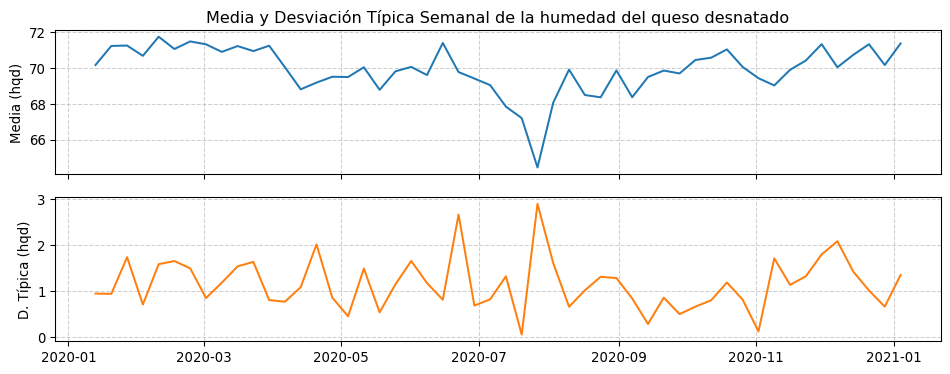

In [27]:
df['hqd'] = ((100 - df['est']) / (100 - df['mg'])) * 100

# --- 1. Preparación de los datos (Calculando la Media y la Desviación Típica Semanal) ---
media_semanal = df["hqd"].resample('W-MON').mean()
dt_semanal = df["hqd"].resample('W-MON').std()

# --- 2. Creación de los Subgráficos (El paso clave) ---
# Creamos una figura (conjunto de gráficos) con 2 filas y 1 columna.
# El parámetro 'figsize=(10, 4)' controla el tamaño: 10 de ancho y 4 de alto total (como un gráfico normal).
# 'sharex=True' asegura que ambos gráficos compartan el mismo eje temporal.
fig, (ax1, ax2) = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(10, 4), 
    sharex=True
)

# --- 3. Graficar la Media (Gráfico Superior) ---
ax1.plot(media_semanal, label="Media Semanal", color='tab:blue')
ax1.set_title("Media y Desviación Típica Semanal de la humedad del queso desnatado")
ax1.set_ylabel("Media (hqd)")
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(labelbottom=False) # Quita las etiquetas de fecha/hora del gráfico superior

# --- 4. Graficar la Desviación Típica (Gráfico Inferior) ---
ax2.plot(dt_semanal, label="Desviación Típica Semanal", color='tab:orange')
ax2.set_ylabel("D. Típica (hqd)")
ax2.grid(True, linestyle='--', alpha=0.6)

# Ajusta el espacio entre los gráficos para que no se superpongan
fig.tight_layout() 
plt.show()

#### Análisis de los resultados

Una vez explorados los datos, siempre tenemos que formular hipótesis de trabajo para entender lo que nos dicen, y estudiar estas hipótesis con detalle hasta encontrar una explicación razonable. De estas conclusiones se deducirá una toma de decisiones para la mejora del proceso, que continúa con nuevos análisis y nuebas hipótesis.

A la vista de las series de datos, podemos establecer varias hipótesis:

1. A principio de año ha habido una cantidad de materia grasa anormalmente alta en el queso, que puede haberse debido a un error en la estandarización. De hecho, la composición de la leche en esta época es más rica en MG que el resto del año, lo que puede haber llevado a este error. Sin embargo esto no ha sido un problema porque también el extracto seco ha sido un poco más alto, lo que ha mantenido la `hqd` constante entorno a 71% hasta el mes de mayo.
2. A partir de febrero, se ha intentado corregir la estandarización aumentando la `mg` de forma constante hasta el verano.
3. En mayo se ha mantenido la composición en `mg`, pero se ha subido el `est`, lo que ha llevado a una reducción de `hqd`.
4. En verano se han tenido valores de extracto seco muy altos que han producido una bajada brusca en `hqd`hasta de casi 7 puntos hasta un valor de 65%, lo que es un gran problema para la textura de un queso camembert.
5. Además de esto, los tres valores anómalos que encontramos en el análisis del `jointplot` probablemente sean errores analíticos o de toma de muestras, ya que no se corresponden con el grueso de los valores. Lo más seguro sería eliminarlos del análisis.

### 4. Comunicar: discusión de la información en equipo.

Hemos ido a una reunión de trabajo con el quesero responsable de fabricación del queso, y después de la discusión, hemos obtenido las siguientes conclusiones.

* Debido a las variaciones de composición, el responsable de fabricación nos confirma que, efectivamente, a lolargo del año hace pequeñas modificaciones en la estandarización y el trabajo en cuba, buscando mantener constante la `hqd`.
* El mayor consumo del queso camembert de este fabricante tiene lugar en las zonas costeras del sur y en Canarias, zonas en las que el queso es muy apreciado por los turistas que vienen a España. En verano, debido a que las temperaturas son más altas, suele bajar la `hqd` para evitar problemas de proteoisis excesiva durante el ciclo de comercialización. 
* Este año ha habido un problema adicional en el verano, y es que durante las vacaciones, el quesero ha sido sustituido por una persona con menos experiencia, que ha forzado el extracto seco más de lo debido, y ha habido reclamaciones de consumidores por queso demasiado seco.
* El laboratorio ha confirmado que los valores anómalos sospechosos pueden haber sido debidos a análisis incorrectos, y recomienda no tenerlos en cuenta. En consecuencia, deberíamos repetir el análisis eliminando estos valores, para que las conclusiones no se vean afectadas por ellos.

#### Posible plan de trabajo

A la vista de estos resultados, el equipo propone las siguentes acciones:

1. Revisar diariamente la composición de la leche para evitar errores de estandarización
2. Mejorar la formación a las personas que son responsables de la toma de muestras para evitar errores.
3. Repasar los métodos analíticos con los analistas del laboratorio y posiblemente poner en marcha un estudio sobre la precisión de los análisis, incluyendo la dispersión por analista.
4. Actualizr la información sobre la situación del queso en el punto de venta, con el fin de asegurar la calidad, evitando una sobrecorrección de la `hqd` en los meses de verano.
5. Cuidar las sustituciones en verano en los puntos críticos: quesero y analistas, para no introducir variabilidad por defectos de formación en las personas sustitutas.
6. Anticipar los ciclos de formación a las personas encargadas de sustituir puntos clave en situaciones de enfermedad o vacaciones, mejorando la polivalencia.

Dado que la capacidad de poner planes de ación del equipo es limitada, debido a la carga de trabajo de producción, en sucesivas reuniones se priorizarán los planes de acción que tengan mayor impacto en la calidad y en el coste del producto, y se establecerán calendarios de trabajo e indicadores que reflejen los impactos de las acciones en marcha. Estos indicadores se publicarán semanalmente en paneles situados en la planta, para que el equipo pueda verlos y discutirlos.


## Resumen del capítulo

En este capítulo hemos analizado una fabricación anual de queso camembert y hemos aprendido a detectar posibles errores en los atos, así como a interpretar lo sucedido durante una temporada de fabricación, sacando conclusiones para establecer planes de mejora.

En el capítulo siguiente nos enfrentaremos al análisis de las entradas de leche en una gran fábrica de queso.